<a href="https://colab.research.google.com/github/vishalrk1/tensorflow_Pytorch/blob/main/Pytorh_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
# number of sub processor to use for data loading
num_workers = 0

# batch_size
BATCH_SIZE = 32

#converting data to tensors
transform = transforms.ToTensor()

# train & test dataset
train_data = datasets.MNIST('MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST('MNIST_data/', train=False, download=True, transform=transform)

# dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



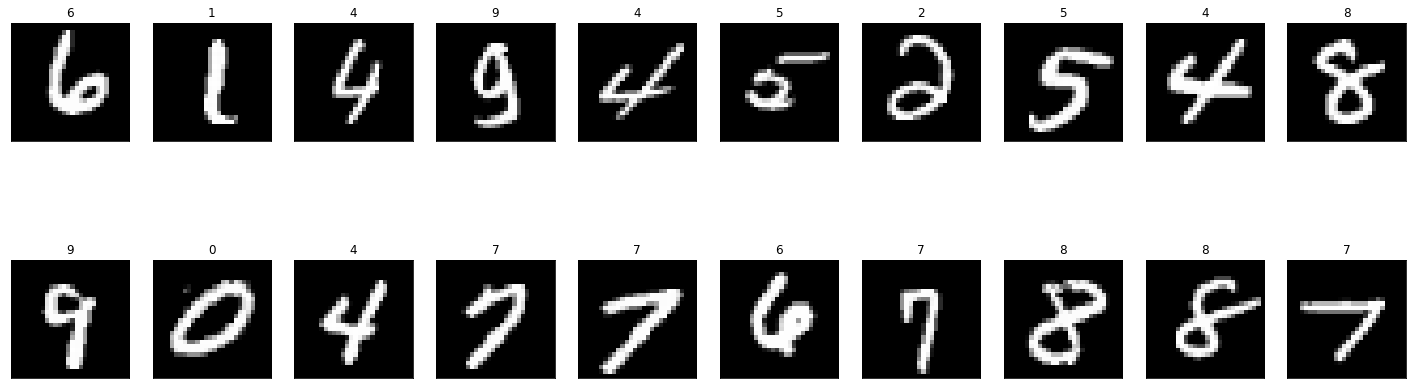

In [ ]:
# plotting few images

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 8))
for idx in  np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(str(labels[idx].item()))

In [2]:
# function to calculate accuracy 
def calculate_acc(model, loader):
  n_correct = 0
  n_total = 0

  for inputs, targets in loader:
    # moving data to gpu
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting prediction
    # torch max returns both max and argmax
    _, preds = torch.max(outputs, 1)

    # Updating counts
    n_correct += (preds == targets).sum().item()
    n_total += targets.shape[0] 

  acc = n_correct / n_total
  return acc

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    hidden_1 = 512
    hidden_2 = 128

    # linear layer (784 --> 512)
    self.fc1 = nn.Linear(28*28*1, hidden_1)
    # linear layer (512 --> 128)
    self.fc2 = nn.Linear(hidden_1, hidden_2)
    # linear layer (128 --> 10)
    self.fc3 = nn.Linear(hidden_2, 10)
    # drop out layer
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    # flatten image input
    x = x.view(-1, 28*28*1)
    # hidden layer with relu activation
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    return x

model = Classifier()
model

Classifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10

for epoch in range(epochs):
  train_loss = 0

  for images, labels in train_dataloader:
    # clearing gradients for all variables
    optimizer.zero_grad()
    # forward pass
    output = model.forward(images)
    # calculating loss
    loss = criterion(output, labels)
    # backward pass
    loss.backward()
    # updating parameters ( single optimizer step )
    optimizer.step()
    # updating train loss
    train_loss += loss.item()*images.size(0)

  else:
    test_loss = 0
    accuracy = 0

    with torch.no_grad():
      model.eval()
      for images, labels in test_dataloader:
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()*images.size(0)

  model.train()
  train_loss = train_loss / len(train_dataloader)
  test_loss = test_loss / len(test_dataloader)
  print(f"Epoch: {epoch+1} \t Training Loss: {train_loss} \t Test Loss: {test_loss}")

# CIFAR 10 dataset

In [3]:
from torch.utils.data import SubsetRandomSampler

In [ ]:
# number of sub processor to use for data loading
num_workers = 0

# batch_size
BATCH_SIZE = 32

# checking for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# choose the training and test datasets
train_data = datasets.CIFAR10(root='CIFAR/', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='CIFAR/', train=False, download=True, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=num_workers)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR/cifar-10-python.tar.gz to CIFAR/
Files already downloaded and verified


In [ ]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## Formula to calculate shape of onvolutional layer

* **(W_in-F+2P)/S+1**
* W_in --> input shape
* F --> filter / kernal_size
* P --> Padding
* S --> stride

In [ ]:
class ConvModel(nn.Module):
  def __init__(self):
    super().__init__()
    # (32, 32, 3)
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    # (16, 16, 16)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    # (8, 8, 32)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    # polling layer --> (4, 4, 64)
    self.pool = nn.MaxPool2d(2, 2)

    # linear layer
    self.fc1 = nn.Linear(64*4*4, 512)
    self.fc2 = nn.Linear(512, 10)

    # dropout layer
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    # flatten images
    x = x.view(-1, 64*4*4)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model = ConvModel()
model.to(device)

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20

valid_loss_min = np.Inf

train_losses = []
valid_losses = []

for epoch in range(epochs):
  train_loss = 0
  valid_loss = 0

  # training Model
  model.train()
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model.forward(images)

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  # validating Model
  model.eval()
  for images, labels in valid_dataloader:
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

  # computing train and test loss
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(valid_dataloader)

  # storing losses for perticular epoch
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss,valid_loss))

Epoch: 1 	Training Loss: 1.600375 	Validation Loss: 1.321843
Epoch: 2 	Training Loss: 1.306355 	Validation Loss: 1.148045
Epoch: 3 	Training Loss: 1.191040 	Validation Loss: 1.074824
Epoch: 4 	Training Loss: 1.120280 	Validation Loss: 1.056858
Epoch: 5 	Training Loss: 1.062843 	Validation Loss: 0.972432
Epoch: 6 	Training Loss: 1.023888 	Validation Loss: 0.943215
Epoch: 7 	Training Loss: 0.991745 	Validation Loss: 0.904255
Epoch: 8 	Training Loss: 0.967295 	Validation Loss: 0.897638
Epoch: 9 	Training Loss: 0.944520 	Validation Loss: 0.867633
Epoch: 10 	Training Loss: 0.925683 	Validation Loss: 0.895506
Epoch: 11 	Training Loss: 0.913752 	Validation Loss: 0.852778
Epoch: 12 	Training Loss: 0.896429 	Validation Loss: 0.819884
Epoch: 13 	Training Loss: 0.884137 	Validation Loss: 0.851171
Epoch: 14 	Training Loss: 0.876376 	Validation Loss: 0.806256
Epoch: 15 	Training Loss: 0.861373 	Validation Loss: 0.806378
Epoch: 16 	Training Loss: 0.856647 	Validation Loss: 0.792813
Epoch: 17 	Traini

In [ ]:
train_acc = calculate_acc(model, train_dataloader)
test_acc = calculate_acc(model, test_dataloader)

print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Training Accuracy: 0.764325
Test Accuracy: 0.7491


# Pizza and Steak transfer learning

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

unzip_data('pizza_steak.zip')

--2021-12-04 05:01:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-04 05:01:24 (43.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2021-12-04 05:01:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (1

In [ ]:
train_dir = '/content/pizza_steak/train/'
test_dir = '/content/pizza_steak/test/'

In [ ]:
# number of sub processor to use for data loading
num_workers = 0

# batch_size
BATCH_SIZE = 32

# checking for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
train_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = (0.485, 0.456, 0.406),
        std = (0.229, 0.224, 0.225),
    ),
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = (0.485, 0.456, 0.406),
        std = (0.229, 0.224, 0.225),
    ),
])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=num_workers)

In [ ]:
train_data.classes

['pizza', 'steak']

In [ ]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# freezing weights
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
classifier = nn.Linear(4096, 2)

model.classifier[6] = classifier

for param in model.classifier[6].parameters():
  param.requires_grad = True

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [ ]:
epochs = 10

train_losses = []
valid_losses = []

for epoch in range(epochs):
  train_loss = 0
  valid_loss = 0

  # training loop
  model.train()
  for images, labels in train_dataloader:

    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  # validation loop
  model.eval()
  for images, labels in valid_dataloader:
     images, labels = images.to(device), labels.to(device)

     output = model(images)
     loss = criterion(output, labels)

     valid_loss += loss.item()

  # computing train and test loss
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(valid_dataloader)

  # storing losses for perticular epoch
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss,valid_loss))

Epoch: 1 	Training Loss: 0.135202 	Validation Loss: 0.154535
Epoch: 2 	Training Loss: 0.124490 	Validation Loss: 0.153641
Epoch: 3 	Training Loss: 0.113705 	Validation Loss: 0.231901
Epoch: 4 	Training Loss: 0.115144 	Validation Loss: 0.161942
Epoch: 5 	Training Loss: 0.092381 	Validation Loss: 0.197396
Epoch: 6 	Training Loss: 0.087443 	Validation Loss: 0.168952
Epoch: 7 	Training Loss: 0.088638 	Validation Loss: 0.171061
Epoch: 8 	Training Loss: 0.084829 	Validation Loss: 0.138156
Epoch: 9 	Training Loss: 0.063143 	Validation Loss: 0.135614
Epoch: 10 	Training Loss: 0.064930 	Validation Loss: 0.167471


In [ ]:
train_acc = calculate_acc(model, train_dataloader)
test_acc = calculate_acc(model, test_dataloader)

print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Training Accuracy: 0.9733333333333334
Test Accuracy: 0.98


# Food 101 => 10 classes

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2021-12-04 05:01:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   143MB/s    in 3.6s    

2021-12-04 05:01:45 (139 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [6]:
train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

In [7]:
# number of sub processor to use for data loading
num_workers = 0

# batch_size
BATCH_SIZE = 32

# checking for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=num_workers)

In [8]:
train_data.class_to_idx

{'chicken_curry': 0,
 'chicken_wings': 1,
 'fried_rice': 2,
 'grilled_salmon': 3,
 'hamburger': 4,
 'ice_cream': 5,
 'pizza': 6,
 'ramen': 7,
 'steak': 8,
 'sushi': 9}

In [9]:
classes = train_data.classes
num_classes = len(classes)

In [19]:
# displaying random images
import random 

def display_random_images(dataset, n=10, classes=None, seed=None):
  if n > 10:
    n = 10
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10.")

  if seed:
    random.seed(seed)  

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through samples and display
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # Min-max scale
    sample_min, sample_max = targ_image.min(), targ_image.max()
    sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

    # Adjust for shape (colour, height, width) -> (height, width, colour)
    sample_adjust = sample_scaled.permute(1, 2, 0)
    # print(sample_adjust)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(sample_adjust)
    plt.axis("off")
    if classes:
      plt.title(classes[targ_label])

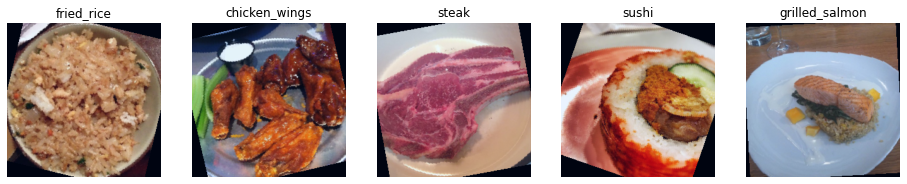

In [20]:
display_random_images(train_data, n=5, classes= classes)

In [23]:
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

In [25]:
model.classifier[1] = nn.Linear(1280, 10)

for param in model.classifier[1].parameters():
  param.requires_grad = True

In [27]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

In [32]:
# Model training

epochs = 10

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

for epoch in range(epochs):
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model.train()
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model.eval()
  for images, labels in valid_dataloader:
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(valid_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(valid_dataloader)

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  print(f'Epoch: {epoch+1}')
  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))

Epoch: 1
Training Loss: 0.967809 	Training Accuracy: 0.72
Validation Loss: 0.879587 	Validation Accuracy: 0.74
Epoch: 2
Training Loss: 0.853392 	Training Accuracy: 0.74
Validation Loss: 0.792885 	Validation Accuracy: 0.76
Epoch: 3
Training Loss: 0.788830 	Training Accuracy: 0.76
Validation Loss: 0.749521 	Validation Accuracy: 0.76
Epoch: 4
Training Loss: 0.759217 	Training Accuracy: 0.76
Validation Loss: 0.723776 	Validation Accuracy: 0.78
Epoch: 5
Training Loss: 0.726151 	Training Accuracy: 0.77
Validation Loss: 0.700802 	Validation Accuracy: 0.78
Epoch: 6
Training Loss: 0.709257 	Training Accuracy: 0.77
Validation Loss: 0.690329 	Validation Accuracy: 0.78
Epoch: 7
Training Loss: 0.706289 	Training Accuracy: 0.78
Validation Loss: 0.675378 	Validation Accuracy: 0.78
Epoch: 8
Training Loss: 0.684701 	Training Accuracy: 0.78
Validation Loss: 0.683517 	Validation Accuracy: 0.78
Epoch: 9
Training Loss: 0.669313 	Training Accuracy: 0.78
Validation Loss: 0.699246 	Validation Accuracy: 0.78
E

In [33]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_losses": [...],
             "train_acc": [...],
             "valid_losses": [...],
             "valid_acc": [...]}
    """
    train_loss = results['train_losses']
    valid_loss = results['valid_losses']

    train_accuracy = results['train_acc']
    valid_accuracy = results['valid_acc']

    epochs = range(len(results['train_losses']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, valid_accuracy, label='validation_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

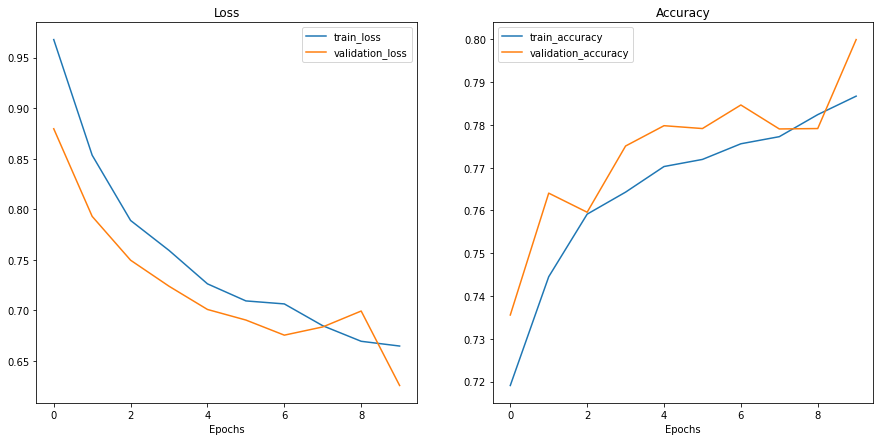

In [34]:
plot_loss_curves(results)